In [1]:
import time
import torch

In [2]:
import torch.nn as nn

In [3]:
import matplotlib.pyplot as plt

In [4]:
# utilities
from cbfverify_barrier_fastlin import get_weights

In [5]:
# 1-layer network with ReLU activation
dim_in, dim_out, num_hidden, num_batch = 3, 1, 256, 1
model = nn.Sequential(
    nn.Linear(dim_in,num_hidden),
    nn.ReLU(),
    nn.Linear(num_hidden,num_hidden),
    nn.ReLU(),
    nn.Linear(num_hidden,dim_out)
)

In [6]:
def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)

model.apply(init_weights)

Sequential(
  (0): Linear(in_features=3, out_features=256, bias=True)
  (1): ReLU()
  (2): Linear(in_features=256, out_features=256, bias=True)
  (3): ReLU()
  (4): Linear(in_features=256, out_features=1, bias=True)
)

In [7]:
Ws, bs = get_weights(model)

W0:torch.Size([256, 3])
b0:torch.Size([256])
W1:torch.Size([256, 256])
b1:torch.Size([256])
W2:torch.Size([1, 256])
b2:torch.Size([1])


In [8]:
# 1k samples
num_sample = 1000
x0 = torch.rand(dim_in,num_sample) # shape: (dim_in, num_batch)

In [9]:
# perturbation magnitude
eps = 0.1

## FastLin bounds, ReLU, Multi-Layer

In [10]:
from cbfverify_barrier_fastlin_batch import get_barrier_bounds_fastlin_batch_mult_layers

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
for w in Ws:
    w.to(device)
for b in bs:
    b.to(device)
x0.to(device)
start = time.time()
UBs, LBs = get_barrier_bounds_fastlin_batch_mult_layers(x0, eps, Ws, bs, method="fastlin", activation="relu")
fastlin_elapsed_batch = time.time() - start
print("Time elapsed: {}".format(fastlin_elapsed_batch))

Time elapsed: 0.9251308441162109


In [12]:
all_outs = []
x = x0.clone().T
all_outs.append(x.T)
for layer in model:
    x = layer(x)
    if type(layer) == nn.modules.linear.Linear:
        all_outs.append(x.detach().T)

In [13]:
# Test bound
for layer_out, LB, UB in zip(all_outs, LBs, UBs):
    assert all((layer_out > LB).cpu().numpy().tolist()[0]), "Lower bound violation"
    assert all((layer_out < UB).cpu().numpy().tolist()[0]), "Upper bound violation"
print("Passed!")

Passed!


## Compare bound tightness between FastLin and IBP, multi-layer

In [14]:
from cbfverify_barrier_fastlin import get_barrier_bounds_ibp

In [15]:
num_sample = 1
x0 = torch.rand(dim_in,num_sample) # shape: (dim_in, num_batch)

In [16]:
model_out = model(x0.T)

In [17]:
fastlin_UBs, fastlin_LBs = get_barrier_bounds_fastlin_batch_mult_layers(x0, eps, Ws, bs, method="fastlin", activation="relu")

In [18]:
ibp_UBs, ibp_LBs = get_barrier_bounds_ibp(x0, eps, Ws, bs, activation="relu")

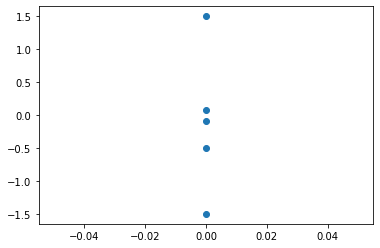

In [19]:
plt.scatter([0 for _ in range(5)], [-1.5, 1.5, 0.08, -0.09, -0.5])

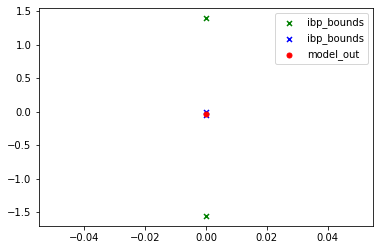

In [20]:
dot_size = 25
plt.scatter([0, 0], 
            [ibp_UBs[-1].squeeze().item(), ibp_LBs[-1].squeeze().item()], 
            label="ibp_bounds", 
            c='g',
            marker='x', 
            s=dot_size)
plt.scatter([0, 0], 
            [fastlin_UBs[-1].squeeze().item(), fastlin_LBs[-1].squeeze().item()], 
            label="ibp_bounds",
            c='b',
            marker='x', 
            s=dot_size)
plt.scatter(0, 
            model_out.squeeze().item(), 
            label="model_out", 
            c='r',
            marker='o', 
            s=dot_size)

plt.legend()